## **Imports Everything.**

In [0]:
import sys
import os
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from numpy import ma
import pandas as pd
from scipy import special
from datetime import datetime
from scipy.stats import binom
from scipy.stats import geom
from scipy.stats import poisson
from scipy import stats
from scipy.fftpack import fft, rfft,ifft
from scipy import fftpack
import statistics

## **Load All Files**

In [0]:
#Github URL for the raw data files
pdX_url = "https://raw.githubusercontent.com/prtsh/CSE-544-Covid19-vs-PresidentialApproval/master/CleanedData-Plots/approval_topline-allpolls.csv"
pdCovid_url = "https://raw.githubusercontent.com/prtsh/CSE-544-Covid19-vs-PresidentialApproval/master/CleanedData-Plots/us.csv"

In [498]:

#Load Panda dataframes
dfX = pd.read_csv(pdX_url, sep=',', error_bad_lines=True) #X dataframe, topline approval rating, all polls
dfCovid = pd.read_csv(pdCovid_url, sep=',',error_bad_lines=True) #Covid 19 USA dataframe
dfCovidCDF = dfCovid.copy()
dfCovid.head(); dfX.head()

,president,subgroup,modeldate,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,timestamp
0,Donald Trump,All polls,4/30/20,42.921096,46.798932,39.043261,52.389264,56.547651,48.230876,4/30/20 15:43
1,Donald Trump,All polls,4/29/20,42.563159,46.281516,38.844803,52.668005,56.718638,48.617373,4/29/20 17:41
2,Donald Trump,All polls,4/28/20,42.599133,46.328493,38.869772,52.571193,56.717958,48.424429,4/28/20 23:02
3,Donald Trump,All polls,4/27/20,43.258787,47.066718,39.450856,52.579022,56.931583,48.226462,4/27/20 15:23
4,Donald Trump,All polls,4/26/20,43.428729,47.251167,39.606291,52.447502,56.861902,48.033102,4/27/20 8:11


In [499]:
dfCovid.tail()

,date,cases,deaths
96,4/26/20,965214,49464
97,4/27/20,988250,50819
98,4/28/20,1012683,53034
99,4/29/20,1039318,55399
100,4/30/20,1069722,57570


In [500]:
#CDF to PDF for the Cofid 19 Death# and Cases# data, daily deaths and daily cases
dfCovid = dfCovid.drop(dfCovid.columns[[0]], axis = 1)
dfCovid = dfCovid.diff(axis = 0, periods=1);
dfCovid.tail()

,cases,deaths
96,26464.0,1139.0
97,23036.0,1355.0
98,24433.0,2215.0
99,26635.0,2365.0
100,30404.0,2171.0


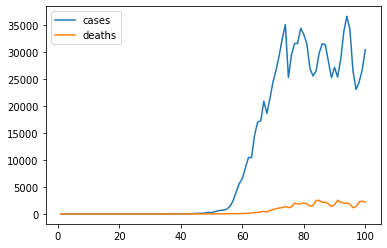

In [501]:
dfCovid.dropna()
dfCovid.plot()

In [502]:
dfXClean = dfX.drop(dfX.columns[[0, 1, 2, 4, 5, 6, 7, 8, 9]], axis = 1)
dfXClean["approve_estimate"] = dfXClean["approve_estimate"].values[::-1]
dfXClean.head()


,approve_estimate
0,42.222053
1,41.909656
2,42.635503
3,43.016357
4,43.016357


## **Tasks**

---



####**1. Data Cleaning and Outliers**

---



1. Missing values and sanitization
From 21st Jan to 30 April we have 100 days of dataset, a manual inspection shows no null/invalid values. Dataframe load with error_bad_lines flag set true shows no load error(this flag catches invalid rows in the csv file)

2. After running Tukey IQR outlier detection algorithm on the entire dataset (21 jan to 30th april) we couldn't find any outliers.

it's observed that these data are at the top end of the exponential growth, in days close to/near the end of April. This could be explained away by the exponential growth of these curves and a very low (close to zero/single digit) value at the start of Feb/mid Feb. 

If we run the tukey 1.5 IQR rule on the last 60 days of data, we see few outliers, but these are during the early days of pandemic. The low values which are classified as outliers and are much smaller than (two orders of magnitude) of the April end values.


1.   Dataset: Covid Cases# Outlier Count:4, Outlier Value:[10.0, 13.0, 15.0, 18.0] (4%)
2.  Dataset: Covid Deaths# Outlier Count:2, Outlier Value:[1.0, 2.0] (2%)
3.   Dataset: Approval Rating Outlier Count:0, Outlier Value:[] (0%)

The data we used (nytimes data on Covid) and fivethirtyeight data on approval ratings are pre-processed and clean, hence we couldn't find any obvious/glaring data glitches.

We also dropped unnecessary columns in Approval rating data (X) dataset, such as time stamp, low approval percentage, high disapproval percentage etc. The rows with any null values (after pdf conversion from cdf) are dropped.




In [0]:
def tukey(datalist, desciption):
  #covid cases outlier detection
  datalist.sort()
  length = len(datalist) #case and death lengths are same, length = 101, odd samples
  if length%2: #for odd length
    median = datalist[round((length+1)/2)]
    i1 = round((length)/4); i3 = round((length)*3/4)
    q1 = (datalist[i1]+datalist[i1+1])/2;
    q3 = (datalist[i3]+datalist[i3+1])/2;  
  else: #for even length
    median = (datalist[round((length)/2)] + datalist[round((length+1)/2)])/2
    i1 = round((length)/4); i3 = round((length)*3/4)
    q1 = (datalist[i1]);
    q3 = (datalist[i3]);  

  IQR = q3 - q1;
  low = q1 - 1.5*IQR;
  high = q3 + 1.5*IQR;
  # outlier range Q1-1.5 IQR or above Q3+1.5 IQR.
  outlier = 0; outlier_list = []
  for value in datalist:
    if value < low or value > high:
      outlier +=1;
      outlier_list.append(value);
  print("Dataset: {} Outlier Count:{}, Outlier Value:{}".format(desciption, outlier, outlier_list))



In [504]:
cases = list(dfCovid['cases'])
deaths = list(dfCovid['deaths'])
tukey(cases, "Covid Cases#");
tukey(deaths, "Covid Deaths#");

Dataset: Covid Cases# Outlier Count:0, Outlier Value:[]
Dataset: Covid Deaths# Outlier Count:0, Outlier Value:[]


In [505]:

#Approval rating outlier detection
#covid cases outlier detection
approval = list(dfXClean['approve_estimate']);
tukey(approval, "Approval Rating");

Dataset: Approval Rating Outlier Count:0, Outlier Value:[]


In [506]:
#outleir for last 60 day data
cases = list(dfCovid['cases'])[:-60]
deaths = list(dfCovid['deaths'])[:-60]
approval = list(dfXClean['approve_estimate'])[:-60]
tukey(cases, "Covid Cases#");
tukey(deaths, "Covid Deaths#");
tukey(approval, "Approval Rating");

Dataset: Covid Cases# Outlier Count:4, Outlier Value:[10.0, 13.0, 15.0, 18.0]
Dataset: Covid Deaths# Outlier Count:2, Outlier Value:[1.0, 2.0]
Dataset: Approval Rating Outlier Count:3, Outlier Value:[41.909656, 42.222053, 44.570087]


In [507]:
dfCovid.tail()

,cases,deaths
96,26464.0,1139.0
97,23036.0,1355.0
98,24433.0,2215.0
99,26635.0,2365.0
100,30404.0,2171.0


In [508]:
#Outlier removal, these are first 5 values from the last 60 days
for outlier_deaths in [10.0, 13.0, 15.0, 18.0]:
  dfCovid = dfCovid[dfCovid.deaths != outlier_deaths]

dfCovid.tail()

,cases,deaths
96,26464.0,1139.0
97,23036.0,1355.0
98,24433.0,2215.0
99,26635.0,2365.0
100,30404.0,2171.0


In [509]:
#removing the corresponding outlier in the Approval dataset, these are the first 5 points
#dfXClean = dfXClean[:-60][5:]
dfXClean.tail()

,approve_estimate
96,43.428729
97,43.258787
98,42.599133
99,42.563159
100,42.921096




####**2. Basic Visualization**

---

**General trend and few observations:**
**Covid dataset**: We observed an exponential growth after the week of 15-21st March, total cases crossed one million by the 28th of April and per day infection crossing 25K. Total death crossed 67K in the same time period, with per day death of ~2.5K. The week of March 15th could be seen as an inflection point. The death# follows the same trend as the #cases graph.The  death value depends on the mortality rate. There is also a lag between the #cases and #death (seen at the inflection point) which could be attributed to the incubation time of time of virus. The rate of growth of number of cases per day and the deaths per day stabilized by the middle of march.


**Approval Estimate** - Approval is cyclical in nature but is bound in the range of 42% (minimum) and 46%(maximum). The peak approval is 1.5% point lower after the 15th March week, compared to the previous peak in early March. (May or maynot be attributed to Covid, and this is examined in the inference, section 4.1). There are no outliers in this dataset.

Please find the plots below.



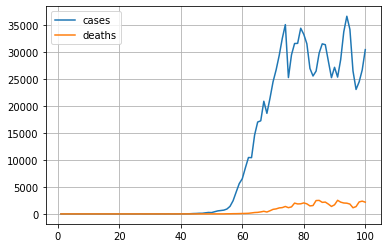

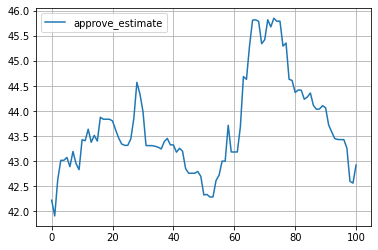

In [510]:
# ToDos
# Plot the cleaned data (Histogram and timeline plots)
# Write a summary/Comment
# Explain the general trends

dfCovid.plot(kind='line', grid=True)
dfXClean.plot(kind='line', grid=True)


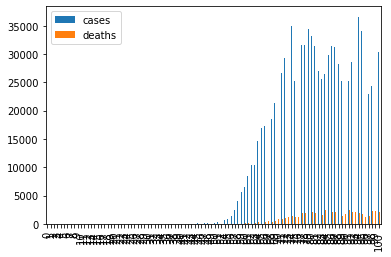

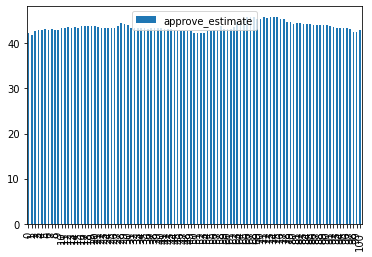

In [511]:
#histogram plot
dfCovid.plot(kind='bar')
dfXClean.plot(kind='bar' )

####**3. Required Inferences**





#####**3.1.** Use your COVID19 dataset to predict the COVID19 fatality and #cases for the next one week. Use the following four prediction techniques: (i) AR(3), (ii) AR(5), (iii) EWMA with alpha = 0.5, and (iv) EWMA with alpha = 0.8. Make sure that your dataset allows you to verify the one week prediction. For example, use the first three weeks of data to predict the fourth week, and report the accuracy of your predictions using the actual fourth week data. Use metrics learned in class (MAPE as a % and MSE) to report accuracy numbers.

EWMA results:
For cases:

Covid CASES EWMA MAPE:2.4834493061938523%, MSE:775305.1824679531

Covid CASES EWMA MAPE:7.57864880555454%, MSE:6379590.352936645

For Deaths:

Covid DEATHS EWMA MAPE:3.7356872716674157%, MSE:7719.560088765177

Covid DEATHS EWMA MAPE:10.231780831776542%, MSE:47517.9968718262


AR results:
I couldn't get the results for AR, but I can see that the "y" values and the "x" values are as according to the slide 24 of course taught in class. the predicted values and the X values are shown (on the rolling basis).
Please see the partial results below.

In [0]:
def MAPE(y_pred, y_real):
  #mean of absolute percentage error
  sum_error = 0
  for i in range(0, len(y_pred)):
    error = abs(y_pred[i] - y_real[i]);
    error = error/ y_real[i];
    sum_error += error
  return sum_error/len(y_pred)*100;


def MSE(y_pred, y_real):
  #mean of square or error
  sum_error = 0
  for i in range(0, len(y_pred)):
    error = abs(y_pred[i] - y_real[i]);
    error = error*error;
    sum_error += error
  return sum_error/len(y_pred)


In [0]:
#Exponential Weighted Moving Average (Alpha = 0.5, alpha = 0.8)
#use the first three weeks of data to predict the fourth week
def ewma(alpha, y):
  #yhat_t1 = alpha*y_t + (1-alpha(*yhat_t0) // and unroll
  #generate a alpha sum for first 3 weeks
  y_t = y[0];
  for i in range(0,21): #no nee dto predict first 3 weeks, using data to find y_sum
    y_t_1 = alpha*y[i] + (1-alpha)*y_t;
    y_t = y_t_1
  
  #print(y_t)
  #predict next week, using previou 3 weeks
  y_pred = [0]*7
  y_actual = y[-8:-1];
  for i in range(0,7):
    y_pred[i] = y_actual[i]*alpha + (1-alpha)*y_t;
    y_t = y_pred[i] #for next prediction

  return y_pred

In [514]:
#MAPE as a % and MSE
fourweekCases =  list(dfCovid['cases'][-29:-1])
fourweekDeaths = list(dfCovid['deaths'][-29:-1])

y_pred = ewma(0.8, fourweekCases);
print("Covid CASES EWMA MAPE:{}%, MSE:{}".format(MAPE(y_pred,fourweekCases[-8:-1]), MSE(y_pred, fourweekCases[-8:-1])));

y_pred = ewma(0.5, fourweekCases);
print("Covid CASES EWMA MAPE:{}%, MSE:{}".format(MAPE(y_pred,fourweekCases[-8:-1]), MSE(y_pred, fourweekCases[-8:-1])));

Covid CASES EWMA MAPE:2.4834493061938523%, MSE:775305.1824679531
Covid CASES EWMA MAPE:7.57864880555454%, MSE:6379590.352936645


In [515]:
y_pred = ewma(0.8, fourweekDeaths);
print("Covid DEATHS EWMA MAPE:{}%, MSE:{}".format(MAPE(y_pred,fourweekDeaths[-8:-1]), MSE(y_pred, fourweekDeaths[-8:-1])));

y_pred = ewma(0.5, fourweekDeaths);
print("Covid DEATHS EWMA MAPE:{}%, MSE:{}".format(MAPE(y_pred,fourweekDeaths[-8:-1]), MSE(y_pred, fourweekDeaths[-8:-1])));

Covid DEATHS EWMA MAPE:3.7356872716674157%, MSE:7719.560088765177
Covid DEATHS EWMA MAPE:10.231780831776542%, MSE:47517.9968718262


In [0]:
#n - number of points, y - data series
#use first 3 weeks to predict fourth week
def AR(y, n):
  #b_ols = inverse(x_t * x)*(x_t * y) 
  #n = number of equations needed
  #np.linalg.inv(a)
  #np.transpose(x)
  rolling = []
  for i in range(0, n):
    rolling = [y[i]] + rolling;
  #print(rolling)
  
  count = 0
  X = np.random.randint(1, size=(n+1, n+1)) #X array
  Y = np.random.randint(1, size=(n+1)) #Y array
  #X[:,0] = 1 #set first column to 1 

  for i in range(n, 21):
    X[i%n+1] = [1] + rolling;
    Y[i%n+1] = y[i];
    print("Y_t+1: {}, X: {}".format(Y[i%n+1], X[i%n+1]))
    rolling.pop(-1); #remove last y ,
    rolling = [y[i]] + rolling; #add new y
    count += 1;
    if count >n:
      #solve for beta #no prediction
      beta = (np.linalg.pinv((np.transpose(X)*X)))*(np.transpose(X)*np.transpose(Y))

  #final week prediction
  #print(beta)
  y_pred = [0]*7
  for i in range(0,7):
    y_pred[i] = (X[i%n+1]*beta);
    X[i%n+1] = [1] + rolling;
    Y[i%n+1] = y[i];
    rolling.pop(0); #remove first y ,
    rolling.append(y[i]); #add new y
    beta = np.linalg.pinv((np.transpose(X)*X))* (np.transpose(X)*np.transpose(Y))
  #print(y_pred)
  return y_pred;

In [517]:
y_pred_1 = AR(fourweekCases, 3);
print("Covid CASES AR MAPE:{}%, MSE:{}".format(MAPE(y_pred_1,fourweekCases[-8:-1]), MSE(y_pred_1, fourweekCases[-8:-1])));

y_pred_1 = AR(fourweekCases, 5);
print("Covid CASES AR MAPE:{}%, MSE:{}".format(MAPE(y_pred_1,fourweekCases[-8:-1]), MSE(y_pred_1, fourweekCases[-8:-1])));

y_pred_1 = AR(fourweekCases, 3);
print("Covid CASES AR MAPE:{}%, MSE:{}".format(MAPE(y_pred_1,fourweekCases[-8:-1]), MSE(y_pred_1, fourweekCases[-8:-1])));

y_pred_1 = AR(fourweekCases, 5);
print("Covid CASES AR MAPE:{}%, MSE:{}".format(MAPE(y_pred_1,fourweekCases[-8:-1]), MSE(y_pred_1, fourweekCases[-8:-1])));

#y_pred_1 = AR(fourweekCases, 5);
#y_pred_1 =AR(fourweekDeaths, 3);
#y_pred_1 =AR(fourweekDeaths, 5);

Y_t+1: 25233, X: [    1 35035 32467 29323]
Y_t+1: 29444, X: [    1 25233 35035 32467]
Y_t+1: 31535, X: [    1 29444 25233 35035]
Y_t+1: 31568, X: [    1 31535 29444 25233]
Y_t+1: 34368, X: [    1 31568 31535 29444]
Y_t+1: 33230, X: [    1 34368 31568 31535]
Y_t+1: 31483, X: [    1 33230 34368 31568]
Y_t+1: 26930, X: [    1 31483 33230 34368]
Y_t+1: 25526, X: [    1 26930 31483 33230]
Y_t+1: 26432, X: [    1 25526 26930 31483]
Y_t+1: 29771, X: [    1 26432 25526 26930]
Y_t+1: 31477, X: [    1 29771 26432 25526]
Y_t+1: 31320, X: [    1 31477 29771 26432]
Y_t+1: 28241, X: [    1 31320 31477 29771]
Y_t+1: 25220, X: [    1 28241 31320 31477]
Y_t+1: 27135, X: [    1 25220 28241 31320]
Y_t+1: 25322, X: [    1 27135 25220 28241]
Y_t+1: 28567, X: [    1 25322 27135 25220]
Covid CASES AR MAPE:[[100.         100.         100.         100.        ]
 [100.         433.58544791 445.84070603 182.92945886]
 [100.         418.77471256 470.97996307 807.51389177]
 [100.         154.42979988 701.47809107 

#####**3.2.  Application of the Wald’s test, Z-test, and T-test**



###### **Data preprocessing**

In [0]:
# Notations
#   LW - Last Week
#   SLW - Second Last Week

alpha = 0.05
LW = dfCovid[-7:]
SLW = dfCovid[-14:-7]
casesLW = LW['cases'].to_numpy().flatten()
casesSLW = SLW['cases'].to_numpy().flatten()
deathLW = LW['deaths'].to_numpy().flatten()
deathSLW = SLW['deaths'].to_numpy().flatten()

###### **Wald's Test**

In [0]:
class WaldsTest:
    LW = None
    SLW = None
    alpha = 0.05
    
    def __init__(self, alpha: float, SLW: np.ndarray, LW: np.ndarray):
        self.alpha = alpha
        self.SLW = SLW
        self.LW = LW

    def oneSample(self)->str:
        lambdaSLW = np.sum(self.SLW)/len(self.SLW)
        lambdaLW = np.sum(self.LW)/len(self.LW) 
        n = float(len(self.LW))
        SE = np.sqrt(lambdaLW/n)

        W = (lambdaLW - lambdaSLW)/SE
        
        if abs(W) > stats.norm.ppf(1 - (alpha/2)):
            return "Null Hypothesis is Rejected"
        else:
            return "Null Hypothesis is NOT Rejected"

    def twoSample(self):
        delta = 0
        n = float(len(self.LW))
        m = float(len(self.SLW))
        
        muLW = np.sum(self.LW)/n
        muSLW = np.sum(self.SLW)/m
        delta_hat = muLW - muSLW
        SE = np.sqrt((muLW/n) + (muSLW/m))
        
        W = (delta_hat - delta)/SE
        
        if abs(W) > stats.norm.ppf(1 - (self.alpha/2)):
            return "Null Hypothesis is Rejected"
        else:
            return "Null Hypothesis is NOT Rejected"

In [520]:
print("\n-------------------Walds Test----------------------------------\n")
testCases = WaldsTest(alpha, casesSLW, casesLW)
testDeaths = WaldsTest(alpha, deathSLW, deathLW)
print("1. Cases")

print("\ta. One Sample Test")
print("\t\t" + testCases.oneSample())

print("\tb. Two Sample Test")
print("\t\t" + testCases.twoSample())

print("2. Deaths")

print("\ta. One Sample Test")
print("\t\t" + testDeaths.oneSample())

print("\tb. Two Sample Test")
print("\t\t" + testDeaths.twoSample())


-------------------Walds Test----------------------------------

1. Cases
	a. One Sample Test
		Null Hypothesis is Rejected
	b. Two Sample Test
		Null Hypothesis is Rejected
2. Deaths
	a. One Sample Test
		Null Hypothesis is Rejected
	b. Two Sample Test
		Null Hypothesis is Rejected


![Walds Test](https://raw.githubusercontent.com/prtsh/CSE-544-Covid19-vs-PresidentialApproval/master/waldsA.jpeg)
![Walds Test](https://raw.githubusercontent.com/prtsh/CSE-544-Covid19-vs-PresidentialApproval/master/waldsB.jpeg)

###### **Z test**

In [0]:
class Ztest:
    LW = None
    SLW = None
    trueSigma2 = None
    alpha = 0.05
    
    def __init__(self, alpha: float, SLW: np.ndarray, LW: np.ndarray, population: np.ndarray):
        self.alpha = alpha
        self.SLW = SLW
        self.LW = LW
        self.trueSigma2 = self.calcTrueSigma2(population)
        
    def calcTrueSigma2(self, data: np.ndarray)->float:
        trueMu = np.sum(data)/float(len(data))
        trueSigma2 = np.sum(np.square(data - trueMu))/float(len(data)-1)
#         print(trueSigma2)
        return trueSigma2
        
    
    def oneSample(self):
        muSLW = np.sum(self.SLW)/float(len(self.SLW))
        n = float(len(self.LW))
        meanLW = np.sum(self.LW)/n
        Z = (meanLW - muSLW)/(np.sqrt(self.trueSigma2/n))
        
        if abs(Z) > stats.norm.ppf(1 - (self.alpha/2)):
            return "Null Hypothesis is Rejected"
        else:
            return "Null Hypothesis is NOT rejected"

In [522]:
print("\n-------------------Z-Test----------------------------------\n")
testCases = Ztest(alpha, casesSLW, casesLW, dfCovid['cases'])
testDeaths = Ztest(alpha, deathSLW, deathLW, dfCovid['deaths'])
print("1. Cases")

print("\ta. One Sample Test")
print("\t\t" + testCases.oneSample())

print("2. Deaths")

print("\ta. One Sample Test")
print("\t\t" + testDeaths.oneSample())


-------------------Z-Test----------------------------------

1. Cases
	a. One Sample Test
		Null Hypothesis is NOT rejected
2. Deaths
	a. One Sample Test
		Null Hypothesis is NOT rejected


![Walds Test](https://raw.githubusercontent.com/prtsh/CSE-544-Covid19-vs-PresidentialApproval/master/zTestNew.jpeg)

###### **T test**

In [0]:
class Ttest:
    LW = None
    SLW = None
    alpha = 0.05
    
    def __init__(self, alpha: float, SLW: np.ndarray, LW: np.ndarray):
        self.alpha = alpha
        self.SLW = SLW
        self.LW = LW
        
    def oneSample(self)->str:
        muSLW = np.sum(self.SLW)/len(self.SLW)
        
        n = float(len(self.LW))
        X_mean = np.sum(self.LW)/len(self.LW)
        # print(self.LW - X_mean)
        # print(np.square(self.LW - X_mean))
        S = np.sqrt(np.sum(np.square(self.LW - X_mean))/(n-1))
        T = (X_mean - muSLW)/(S/np.sqrt(n))

        if abs(T) > stats.t.ppf(1-(self.alpha/2), n-1):
            return "Null Hypothesis is Rejected"
        else:
            return "Null Hypothesis is NOT Rejected"
    
    def twoSamplePaired(self)->str:
        D_0 = 0
        D = self.LW - self.SLW
        n = float(len(D))
        D_mean = np.sum(D)/n
        
        Sd = np.std(D)
        
        T = (D_mean - D_0)/(Sd/np.sqrt(n))
        
        if abs(T) > stats.t.ppf(1 - (alpha/2), n-1):
            return "Null Hypothesis is Rejected"
        else:
            return "Null Hypothesis is NOT Rejected"
    
    def twoSampleUnpaired(self)->str:
        D_0 = 0
        n = float(len(self.LW))
        m = float(len(self.SLW))
        
        meanLW = np.sum(self.LW)/n
        meanSLW = np.sum(self.SLW)/m
        D_mean = meanLW - meanSLW
        
        varLW = np.sum(np.square(self.LW - meanLW))/(n-1)
        varSLW = np.sum(np.square(self.SLW - meanSLW))/(n-1)
        Sd = np.sqrt((varLW/n) + (varSLW/m))
        
        # T = (D_mean - D_0)/(Sd/np.sqrt(n))
        T = (D_mean - D_0)/Sd
        
        if abs(T) > stats.t.ppf(1 - (alpha/2), n+m-2):
            return "Null Hypothesis is Rejected"
        else:
            return "Null Hypothesis is NOT Rejected"

In [524]:
print("\n-------------------T-Test----------------------------------\n")
testCases = Ttest(alpha, casesSLW, casesLW)
testDeaths = Ttest(alpha, deathSLW, deathLW)
print("1. Cases")

print("\ta. One Sample Test")
print("\t\t" + testCases.oneSample())

print("\tb. Two Sample PAIRED Test")
print("\t\t" + testCases.twoSamplePaired())

print("\tb. Two Sample Unpaired Test")
print("\t\t" + testDeaths.twoSampleUnpaired())

print("2. Deaths")

print("\ta. One Sample Test")
print("\t\t" + testDeaths.oneSample())

print("\tb. Two Sample Paired Test")
print("\t\t" + testDeaths.twoSamplePaired())

print("\tb. Two Sample Unpaired Test")
print("\t\t" + testDeaths.twoSampleUnpaired())


-------------------T-Test----------------------------------

1. Cases
	a. One Sample Test
		Null Hypothesis is NOT Rejected
	b. Two Sample PAIRED Test
		Null Hypothesis is NOT Rejected
	b. Two Sample Unpaired Test
		Null Hypothesis is NOT Rejected
2. Deaths
	a. One Sample Test
		Null Hypothesis is NOT Rejected
	b. Two Sample Paired Test
		Null Hypothesis is NOT Rejected
	b. Two Sample Unpaired Test
		Null Hypothesis is NOT Rejected


![Walds Test](https://raw.githubusercontent.com/prtsh/CSE-544-Covid19-vs-PresidentialApproval/master/tTestA.jpeg)
![Walds Test](https://raw.githubusercontent.com/prtsh/CSE-544-Covid19-vs-PresidentialApproval/master/tTestB.jpeg)

###**Applicability**
####*One Sample*
T-Test is applicable here as main objective of one sample t-test is to compare sample mean of one group with an unknown mean
####*Two Sample Paired*
T-test here for two sample paired is not applicable since we it is not clearly determined whether two sets last week and second last weeks data are dependent on each other or not 
####*Two Sample UnPaired*
T-test here for two sample paired is not applicable since we it is not clearly determined whether two sets last week and second last weeks data are dependent on each other or not

In [0]:
# 

#####**3.3** **Application of KS test and Permutation test.**



For Permutation test, 1-sampled KS test and 2-sampled KS test; **the Null Hypotheses is: The distributions of second-last week and last week are same.**

In [0]:
# Todo
def permutation_test(list1, list2, no_permutations):
	N = no_permutations
	T_obs = abs(np.mean(list1) - np.mean(list2))

	counter = 0
	l1=[]

	for i in range(N):
		list1_i = np.random.choice(list1 + list2, size = len(list1), replace = False)
		list2_i = np.random.choice(list1 + list2, size = len(list2), replace = False)
		list1_i_mean = np.mean(list1_i)
		list2_i_mean = np.mean(list2_i)
		T_i = abs(list1_i_mean - list2_i_mean)
		l1.append(T_i)

		
		if T_i > T_obs:
			counter += 1


	p_val = counter/N
	return p_val

In [0]:
def onesamp_KS_test(data1,data2):
	data1 = ma.asarray(data1)
	data2 = ma.asarray(data2)
	n1  = data1.count()
	n2 =  data2.count()
	X = data1.compressed()
	Y = data2.compressed()
	mix = ma.concatenate((X, Y))
	mixsort = mix.argsort(kind='mergesort')
	csum = np.where(mixsort < n1, 1./n1, -1./n2).cumsum()


	length = len(np.unique(mix))
	if length < (n1+n2):
	    ind = np.r_[np.diff(mix[mixsort]).nonzero()[0], -1]
	    csum = csum[ind]
	    mixsort = mixsort[ind]

	csumabs = ma.abs(csum)
	i = csumabs.argmax()

	d = abs(csum[i])
	x = mix[mixsort[i]]

	return d, x


In [0]:
def twosamp_KS_test(data1, data2):
	data1 = ma.asarray(data1)
	data2 = ma.asarray(data2)
	n1  = data1.count()
	n2 =  data2.count()
	X = data1.compressed()
	Y = data2.compressed()
	mix = ma.concatenate((X, Y))
	mixsort = mix.argsort(kind='mergesort')
	csum = np.where(mixsort < n1, 1./n1, -1./n2).cumsum()



	length = len(np.unique(mix))
	if length < (n1+n2):
	    ind = np.r_[np.diff(mix[mixsort]).nonzero()[0], -1]
	    csum = csum[ind]
	    mixsort = mixsort[ind]

	csumabs = ma.abs(csum)
	i = csumabs.argmax()

	d = abs(csum[i])
	x = mix[mixsort[i]]

	return d, x


In [0]:
X = dfCovidCDF
X_second_last=X[-14:-7]
X_last=X[-7:]
case1=list(X_second_last['cases'])
case2=list(X_last['cases'])
death1=list(X_second_last['deaths'])
death2=list(X_last['deaths'])

# X_pdf = dfCovid
# X_second_last_pdf=X_pdf[-14:-7]
# X_last_pdf=X_pdf[-7:]
# case1_pdf=list(X_second_last_pdf['cases'])
# case2_pdf=list(X_last_pdf['cases'])
# death1_pdf=list(X_second_last_pdf['deaths'])
# death2_pdf=list(X_last_pdf['deaths'])


In [530]:
# ---------------------------------- Permutation test -----------------------------------------------

print("Permutation Test")
print("-----------  1: cases for N = 20 permutations --------------")
p_value = permutation_test(case1, case2, 20)
print("p_value  for N = 20 is:", p_value)
if p_value < 0.05:
 	print("Null hypothesis is rejected because p_value < 0.05")
else:
 	print("Null hypothesis is accepted because p_value > 0.05")


print("-----------  2: deaths for N = 20 permutations --------------")
p_value = permutation_test(death1, death2, 20)
print("p_value for N = 20 is:", p_value)

if p_value < 0.05:
 	print("Null hypothesis is rejected because p_value < 0.05")
else:
 	print("Null hypothesis is accepted because p_value > 0.05")


  


Permutation Test
-----------  1: cases for N = 20 permutations --------------
p_value  for N = 20 is: 0.0
Null hypothesis is rejected because p_value < 0.05
-----------  2: deaths for N = 20 permutations --------------
p_value for N = 20 is: 0.0
Null hypothesis is rejected because p_value < 0.05


In [531]:

# ----------------------------------- 2 Sampled KS Test -----------------------------------------------
print("2-Sampled KS Test")
print("----------------- Case 1: 2 Sampled KS_test for cases -----------------------")
KS_stat, point = twosamp_KS_test(case1, case2)
print("KS_statistic for case 1 is {} at point X = {} ".format(KS_stat, point))


if KS_stat > 0.05:
 	print("Null hypothesis is rejected because KS_stat > 0.05")
else:
 	print("Null hypothesis is accepted because KS_stat < 0.05")


print("----------------- Case 2: 2 Sampled KS_test for deaths -----------------------")
KS_stat, point = twosamp_KS_test(death1, death2)
print("KS_statistic for case 2 is {} at point X = {} ".format(KS_stat, point))

if KS_stat > 0.05:
 	print("Null hypothesis is rejected because KS_stat > 0.05")
else:
 	print("Null hypothesis is accepted because KS_stat < 0.05")


2-Sampled KS Test
----------------- Case 1: 2 Sampled KS_test for cases -----------------------
KS_statistic for case 1 is 0.9999999999999998 at point X = 868019 
Null hypothesis is rejected because KS_stat > 0.05
----------------- Case 2: 2 Sampled KS_test for deaths -----------------------
KS_statistic for case 2 is 0.9999999999999998 at point X = 44516 
Null hypothesis is rejected because KS_stat > 0.05


![MME calculation](https://raw.githubusercontent.com/prtsh/CSE-544-Covid19-vs-PresidentialApproval/master/i1.jpeg)

![MME calculation](https://raw.githubusercontent.com/prtsh/CSE-544-Covid19-vs-PresidentialApproval/master/i2.jpeg)


In [532]:

  # ----------------------------------- 1 Sampled KS Test -----------------------------------------------
print("1-Sampled KS Test")
print("----------------- Case 1: 1 Sampled KS_test for cases -----------------------")
  
##Geometric:
MMEparamGeometric_p = len(case1)/sum(case1)
print("Geometric:")
cdf_geometric=geom.cdf(case1, MMEparamGeometric_p)
# print(cdf_geometric)
#print(stats.kstest(case2, 'geom', args=(MMEparamGeometric_p)))
KS_stat, point = onesamp_KS_test(cdf_geometric, case2)
print("KS_statistic for case 1 is {} at point X = {} ".format(KS_stat, point))
if KS_stat > 0.05:
  print("Null hypothesis is rejected because KS_stat > 0.05")
else:
  print("Null hypothesis is accepted because KS_stat < 0.05")

	##Binomial:
MMEparamBinomial_p = sum(case1) / (len(case1) * len(case1))
print("Binomial:")
cdf_binomial= binom.cdf(case1,len(case1), MMEparamBinomial_p)
#print(cdf_binomial)
#print(stats.kstest(case2, 'binom', args=(len(case1), MMEparamBinomial_p)))
KS_stat, point = onesamp_KS_test(cdf_binomial, case2)
print("KS_statistic for case 1 is {} at point X = {} ".format(KS_stat, point))
if KS_stat > 0.05:
  print("Null hypothesis is rejected because KS_stat > 0.05")
else:
  print("Null hypothesis is accepted because KS_stat < 0.05")

##poisson:
MMEparamPoisson_lambda = sum(case1) / len(case1)
print("poisson:")
cdf_poisson=poisson.cdf(case1, MMEparamPoisson_lambda)
# print(cdf_poisson)
# #print(stats.kstest(case2, 'poisson', args=(MMEparamPoisson_lambda)))
KS_stat, point = onesamp_KS_test(cdf_poisson, case2)
print("KS_statistic for case 1 is {} at point X = {} ".format(KS_stat, point))
if KS_stat > 0.05:
  print("Null hypothesis is rejected because KS_stat > 0.05")
else:
  print("Null hypothesis is accepted because KS_stat < 0.05")
print("----------------- Case 2: 1 Sampled KS_test for deaths -----------------------")
##Geometric:
MMEparamGeometric_p = len(death1) / sum(death1)
print("Geometric:")
cdf_geometric=geom.cdf(death1, MMEparamGeometric_p)
# print(cdf_geometric)
# print(stats.kstest(death2, 'geom', args=(MMEparamGeometric_p)))
KS_stat, point = onesamp_KS_test(cdf_geometric, death2)
print("KS_statistic for case 1 is {} at point X = {} ".format(KS_stat, point))
if KS_stat > 0.05:
  print("Null hypothesis is rejected because KS_stat > 0.05")
else:
  print("Null hypothesis is accepted because KS_stat < 0.05")

#Binomial:
MMEparamBinomial_p = sum(death1) / (len(death1) * len(death1))
print("Binomial:")
cdf_binomial=binom.cdf(death1,len(death1), MMEparamBinomial_p)
# print(cdf_binomial)
# print(stats.kstest(death2, 'binom', args=(len(death1), MMEparamBinomial_p)))
KS_stat, point = onesamp_KS_test(cdf_binomial, death2)
print("KS_statistic for case 1 is {} at point X = {} ".format(KS_stat, point))
if KS_stat > 0.05:
	print("Null hypothesis is rejected because KS_stat > 0.05")
else:
	print("Null hypothesis is accepted because KS_stat < 0.05")
 ##poisson:
MMEparamPoisson_lambda = sum(death1) / len(death1)
print("poisson:")
cdf_poisson=poisson.cdf(death1, MMEparamPoisson_lambda)
# print(cdf_poisson)
# #print(stats.kstest(death2, 'poisson', args=(MMEparamPoisson_lambda)))
KS_stat, point = onesamp_KS_test(cdf_poisson, death2)
print("KS_statistic for case 1 is {} at point X = {} ".format(KS_stat, point))
if KS_stat > 0.05:
	print("Null hypothesis is rejected because KS_stat > 0.05")
else:
 	print("Null hypothesis is accepted because KS_stat < 0.05")



1-Sampled KS Test
----------------- Case 1: 1 Sampled KS_test for cases -----------------------
Geometric:
KS_statistic for case 1 is 0.9999999999999998 at point X = 0.6707190792564305 
Null hypothesis is rejected because KS_stat > 0.05
Binomial:
KS_statistic for case 1 is 0.9999999999999998 at point X = 1.0 
Null hypothesis is rejected because KS_stat > 0.05
poisson:
KS_statistic for case 1 is 0.9999999999999998 at point X = 1.0 
Null hypothesis is rejected because KS_stat > 0.05
----------------- Case 2: 1 Sampled KS_test for deaths -----------------------
Geometric:
KS_statistic for case 1 is 0.9999999999999998 at point X = 0.6861978938306901 
Null hypothesis is rejected because KS_stat > 0.05
Binomial:
KS_statistic for case 1 is 0.9999999999999998 at point X = 1.0 
Null hypothesis is rejected because KS_stat > 0.05
poisson:
KS_statistic for case 1 is 0.9999999999999998 at point X = 1.0 
Null hypothesis is rejected because KS_stat > 0.05


#####**3.4.** **[Siddhanth]** Report the Pearson correlation value for #deaths and your X dataset, and also for #cases and your X dataset over one month of data. Use the most relevant column in X to compare against the covid numbers.


In [0]:
# Todo
#X dataset's approval estimates for April
Approval_estimates = dfXClean['approve_estimate'].to_list()
Approval_estimates = Approval_estimates[71:102]

#Covid dataset's #cases for April
no_cases = dfCovid['cases'].to_list()
no_cases = no_cases[70:]

#Covid dataset's #deaths for April
no_deaths = dfCovid['deaths'].to_list()
no_deaths = no_deaths[70:]

In [0]:
#Pearson Correlation for Covid #cases vs trump approval ratings for the month of April
def pearson(X, Y):
  mean1 = sum(X)/len(X)
  mean2 = sum(Y)/len(Y)
  covariance = 0
  std_dev1 = 0
  std_dev2 = 0
  variance1 = 0
  variance2 = 0

  #covariance calculation
  for i in range(0,len(X)):
    covariance += (X[i] - mean1)*(Y[i] - mean2);

  #variance of dataset 1
  for i in range(0, len(X)):
    variance1 += (X[i] - mean1)*(X[i] - mean1);
  
  #standard deviation of dataset 1
  std_dev1 = math.sqrt(variance1)

  #variance of dataset 2
  for i in range(0, len(Y)):
    variance2 += (Y[i] - mean2)*(Y[i] - mean2);
  
  #standard deviation of dataset 2
  std_dev2 = math.sqrt(variance2)

  #pearson correlation calculation = covariance/(standard deviation of dataset 1 * standard deviation of dataset 2)
  pearson1 = covariance/(std_dev1 * std_dev2)
  print(pearson1)

In [535]:
pearson(Approval_estimates,no_cases)

0.18652264961497333


In [536]:
pearson(Approval_estimates,no_deaths)

-0.5777949296329931


1)Thus we can clearly see that the Presidential approval ratings and number of cases of covid19 in March are very weakly **postively** correlated with a pearson correlation value of 0.1865. 

This shows that the approval ratings for month of april doesn't depend much on the daily number of cases of Covid19

2)The Presidential approval ratings and number of deaths due to covid19 in March are strongly **negatively** correlated with a pearson correlation value of -0.577. 

This correlation value are quite obvious as it is evident if the number of deaths keeps increasing, there is a loss of trust in the president's capability to deal with such a pandemic and thus the approval ratings tend to decrease. The fairly high negative correlation value shows how strongly these are dependent on each other.

#####**3.5.** Assume the daily deaths are Poisson distributed with parameter lambda. Assume an Exponential prior (with mean beta) on lambda. To find beta for the prior, equate the mean of the Exponential prior to that of the Poisson lambda_MME. That is, find the MME of lambda using the first week’s data, and equate this lambda to the mean of Exp(1/beta) to find beta for the prior. Use first week’s data to obtain the posterior for lambda via Bayesian inference. Now, use second week’s data to obtain the new posterior, using prior as posterior after week 1. Repeat till the end of week 4. Plot all posterior distributions on one graph. Report the MAP for all posteriors.


In [0]:
# Todo
#list of deaths for all months
data1 = dfCovid['deaths'].to_list()

#list of deaths for month of March(for ease of calculations and decent scale of graph)
march_deaths = data1[40:70]

In [0]:
#Daily deaths for the month of March
#Poisson lambda MME is nothing but the mean X-bar of first week of data
week1 = march_deaths[:7]
mean_week1 = statistics.mean(week1)

#Given that we have to equate mean of first week of data to poisson's lambda_mme 
poisson_lambda_mme = mean_week1

#Given we have to equate poisson lambda mme to exponential prior mean beta
exp_mean_beta = poisson_lambda_mme

In [0]:
#Function to plot gamma distribution
def plotgraph(alpha, beta):
  plt.figure(figsize = (15, 10))
  print("\n")
  for i in range(4):
      #setting range for X-axis
      x = np.linspace(0, 125, 1000)
      
      #storing gamma distribution values for x, alpha and beta, iteration wise
      y = stats.gamma.pdf(x, alpha[i], scale = 1/beta[i])
      
      #MAP of posterior
      max_x = x[y.argmax()]

      #plot X against Y
      plt.plot(x, y, label='Iteration:{}'.format(i+1), linewidth=2)
      print("Iteration: {} Estimated Posterior's MAP: {}".format(i+1, max_x))
  
  plt.title('Posterior Estimation')
  plt.ylabel('probability density', fontsize=14)
  plt.xlabel('', fontsize=14)
  plt.legend(loc='upper right')
  plt.show()
    
def BayesianInference(data):
  #inital prior is an exponential with lambda_exp = lambda and mean = beta_exp
  gamma_alpha   = [None for _ in range(4)]
  gamma_beta = [None for _ in range(4)]
  sum_data = 0
  
  for i in range(4):

    #Sum of data will include week1 data for 1st iteration, week1 + week2 data for 2nd iteration and so on
    for j in data[:(i+1)*7]:
      sum_data += j
    
    #To set prior for next iteration
    #alpha = summation_from_1_to_n(data) + 1, n keeps updating iteration wise
    gamma_alpha[i] = sum_data + 1;
    
    #beta = n + 1/beta_of_exponential, n keeps updating iteration wise
    gamma_beta[i] = ((i+1)*7) + (1/exp_mean_beta);
  
    print("Iteration: {} Estimated Posterior's alpha: {}, beta: {}".format(i+1, gamma_alpha[i], gamma_beta[i]))
  
  plotgraph(gamma_alpha, gamma_beta)

Iteration: 1 Estimated Posterior's alpha: 19.0, beta: 7.388888888888889
Iteration: 2 Estimated Posterior's alpha: 76.0, beta: 14.38888888888889
Iteration: 3 Estimated Posterior's alpha: 500.0, beta: 21.38888888888889
Iteration: 4 Estimated Posterior's alpha: 2976.0, beta: 28.38888888888889


Iteration: 1 Estimated Posterior's MAP: 2.3773773773773774
Iteration: 2 Estimated Posterior's MAP: 5.255255255255256
Iteration: 3 Estimated Posterior's MAP: 23.273273273273276
Iteration: 4 Estimated Posterior's MAP: 104.85485485485486


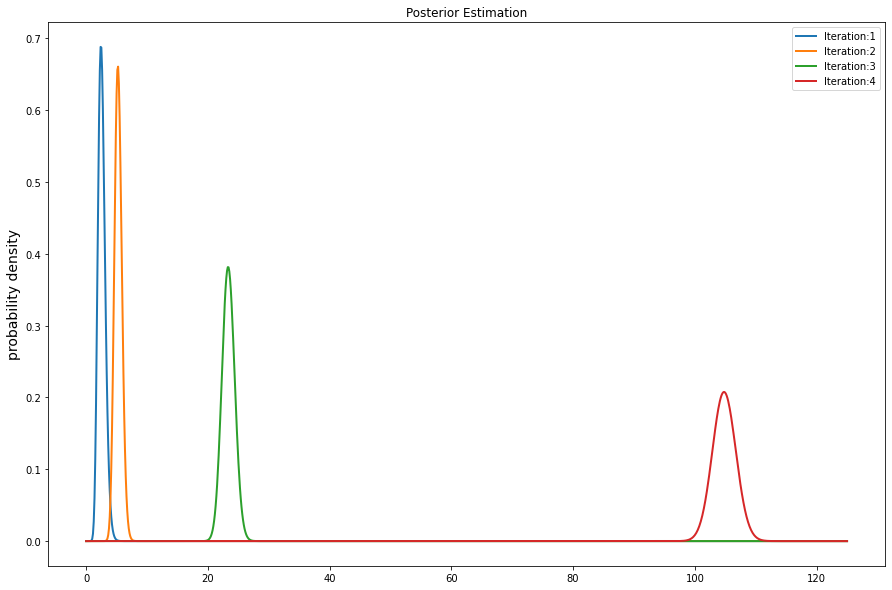

In [540]:
#call function and plot graph
BayesianInference(march_deaths)

We can observe from the graph that the variance does not change much over the posterior estimations. Only the mean increases as the weeks progress and new data is observed. 

When we solve the equation in the problem statement to obtain posterior for lambda, we observe that it is proportional to a gamma distribution with parameters alpha and beta given by

**Alpha** = summation_from_1_to_n(data) + 1

**Beta** = n + 1/beta_of_exponential_prior 

A more detailed solving of how alpha and beta are obtained is attached below:-


![Working](https://raw.githubusercontent.com/prtsh/CSE-544-Covid19-vs-PresidentialApproval/master/IMG_20200512_154142.jpg)

####**4. Sample Inferences** 
**For each inference you propose, provide a paragraph of text to explain why this inference is practical and useful. Also comment on the results of your inference, as appropriate. See “Sample inferences” section below for ideas.**

#####**4.1.**  Check if COVID19 data changed after some local event or rule was enforced, like lockdown or stay-at-home, etc. For this, compare COVID19 data before and after the event. Maybe take into account that COVID19 takes some time to show symptoms, so maybe give some time to allow the lockdown to show its effects.


We check using Permutation test and 2-sampled KS test if the distribution of cases and deaths are same. We consider data from 01/21/2020 to 03/15/2020 as pre-lockdown and from 04/01/2020 to 04/30/2020 as post-lockdown.
Here, we have kept a 15 day gap (from 03/15 to 03/30) to allow the lockdown to show its effects; since COVID19 takes some time to show its symptoms; **the Null Hypotheses is: The distributions (both number of cases and number of deaths) of pre-lockdown and post-lockdown are same.**

In [0]:
# Todo
# Todo
X = dfCovidCDF
X_pre_lockdown = X[0:55]
X_post_lockdown = X[-30:]
case_1 = list(X_pre_lockdown['cases'])
case_2 = list(X_post_lockdown['cases'])
death_1 = list(X_pre_lockdown['deaths'])
death_2 = list(X_post_lockdown['deaths'])

# X_pdf = dfCovid
# X_pre_lockdown_pdf = X_pdf[0:55]
# X_post_lockdown_pdf = X_pdf[-30:]
# case_1_pdf = list(X_pre_lockdown_pdf['cases'])
# case_2_pdf = list(X_post_lockdown_pdf['cases'])
# death_1_pdf = list(X_pre_lockdown_pdf['deaths'])
# death_2_pdf = list(X_post_lockdown_pdf['deaths'])



In [542]:
# ---------------------------------- Permutation test -----------------------------------------------

print("Permutation Test")
print("-----------  1: cases for N = 20 permutations --------------")
p_value = permutation_test(case_1, case_2, 20)
# print(case_1)
print("p_value  for N = 20 is:", p_value)
if p_value < 0.05:
 	print("Null hypothesis is rejected because p_value < 0.05")
else:
 	print("Null hypothesis is accepted because p_value > 0.05")


print("-----------  2: deaths for N = 20 permutations --------------")
p_value = permutation_test(death_1, death_2, 20)
print("p_value for N = 20 is:", p_value)

if p_value < 0.05:
 	print("Null hypothesis is rejected because p_value < 0.05")
else:
 	print("Null hypothesis is accepted because p_value > 0.05")


  


Permutation Test
-----------  1: cases for N = 20 permutations --------------
p_value  for N = 20 is: 0.0
Null hypothesis is rejected because p_value < 0.05
-----------  2: deaths for N = 20 permutations --------------
p_value for N = 20 is: 0.0
Null hypothesis is rejected because p_value < 0.05


In [543]:

# ----------------------------------- 2 Sampled KS Test -----------------------------------------------
print("2-Sampled KS Test")
print("----------------- Case 1: 2 Sampled KS_test for cases -----------------------")
KS_stat, point = twosamp_KS_test(case_1, case_2)
print("KS_statistic for case 1 is {} at point X = {} ".format(KS_stat, point))


if KS_stat > 0.05:
 	print("Null hypothesis is rejected because KS_stat > 0.05")
else:
 	print("Null hypothesis is accepted because KS_stat < 0.05")


print("----------------- Case 2: 2 Sampled KS_test for deaths -----------------------")
KS_stat, point = twosamp_KS_test(death_1, death_2)
print("KS_statistic for case 2 is {} at point X = {} ".format(KS_stat, point))

if KS_stat > 0.05:
 	print("Null hypothesis is rejected because KS_stat > 0.05")
else:
 	print("Null hypothesis is accepted because KS_stat < 0.05")


2-Sampled KS Test
----------------- Case 1: 2 Sampled KS_test for cases -----------------------
KS_statistic for case 1 is 1.0000000000000002 at point X = 3600 
Null hypothesis is rejected because KS_stat > 0.05
----------------- Case 2: 2 Sampled KS_test for deaths -----------------------
KS_statistic for case 2 is 1.0000000000000002 at point X = 68 
Null hypothesis is rejected because KS_stat > 0.05


#####**4.2.**Use Chi-square independence test to check if COVID19 impacted your X dataset in some way.

Data taken in the last 30 days where the fluctuations in Approval rating and the
covid cases are observed.
Converting the time series data by applying following transformation:

**Categories 1** | count of Approval higher than median, Approval Lower than median

**Categories 2** | count Cases Higher than median , Cases lower than median


**Null Hypothesis : Approval rating is independent of the case count**


The chi value obtained is 6.01. The degree of freedom is 1.
The P-Value is .013518. The result is significant at p < .05.
Hence we reject the Null Hypothesis - **Approval rating is independent of the case count**

The same is true for the Null hypothesis - **Approval rating is independent of the Death count**

This shows us that the Trump's approval rating and the increase in the Covid Cases are not independent in the last 6 weeks!



In [0]:
from numpy import median
#function to find relation count between two datasets
def findrelation(mode1, data1, mode2, data2): 
  #cases, rating, high, high
  median1  = median(data1)
  median2  = median(data2)
  relationCount = 0;
  obs1 = [0]*len(data1); obs2 = [0]*len(data2);
  for i in range(0, len(data1)):
    if mode1 == "high":
      obs1[i] = int(data1[i] > median1)
    else:
      obs1[i] = int(data1[i] < median1)
    if mode2 == "high":
      obs2[i] = int(data2[i] > median2)
    else:
      obs2[i] = int(data2[i] < median2)

  # find intersection of the two lists, and return, 
  # this gives us count relation when both variables are higher than median
  # or when both variables are lower than median
  for i in range(len(data1)):
    if obs1[i] == 1 and obs2[i] == 1:
      relationCount +=1;
  return relationCount


In [545]:

#----------------------------------DATA Processing----------------------------------------------------
approval_rating = list(dfX['approve_estimate'])[-45:-1]
cases = list(dfCovid['cases'])[-45:-1]
deaths = list(dfCovid['deaths'])[-45:-1]

median_rating = median(approval_rating)
median_cases  = median(cases)
median_deaths = median(deaths)

print(median_rating, median_cases, median_deaths);

#find count of each Variables, for observation, not used in caluations
HighRating = [i for i in approval_rating if i > median_rating]
HighRatingCount = len(HighRating)

LowRating = [i for i in approval_rating if i <= median_rating]
LowRatingCount = len(LowRating)

HighCases = [i for i in cases if i > median_cases]
HighCasesCount = len(HighCases)

LowCases = [i for i in cases if i <= median_cases]
LowCasesCount = len(LowCases)

HighDeaths = [i for i in deaths if i > median_deaths]
HighDeathsCount = len(HighDeaths)

LowDeaths = [i for i in deaths if i <= median_deaths]
LowDeathsCount = len(LowDeaths)

43.324428999999995 26448.0 1366.5


In [546]:
#Cases and Ratings

# Observations (cases and ratings)
o_HighCasesHighRating = findrelation("high", cases, "high", approval_rating);
o_HighCasesLowRating = findrelation("high", cases, "low", approval_rating);
o_LowCasesHighRating = findrelation("low", cases, "high", approval_rating);
o_LowCasesLowRating  = findrelation("low", cases, "low", approval_rating);
print(o_HighCasesHighRating, o_HighCasesLowRating, o_LowCasesHighRating, o_LowCasesLowRating) 

highcases = o_HighCasesHighRating + o_HighCasesLowRating
lowcases = o_LowCasesHighRating + o_LowCasesLowRating
highrating = o_HighCasesHighRating +  o_LowCasesHighRating
lowrating = o_HighCasesLowRating +  o_LowCasesLowRating;

totalsum = highcases + lowcases

#expected
e_HighCasesHighRating = highrating*highcases/totalsum;
e_HighCasesLowRating = lowrating*highcases/totalsum;
e_LowCasesHighRating = lowcases*highrating/totalsum;
e_LowCasesLowRating = lowcases*lowrating/totalsum;

# Chi Sq = sum of ((observed - expected)^2)/expected

Chi_Sq1  = ((o_HighCasesHighRating - e_HighCasesHighRating)**2)/e_HighCasesHighRating;
Chi_Sq1 += ((o_HighCasesLowRating - e_HighCasesLowRating)**2)/e_HighCasesLowRating;
Chi_Sq1 += ((o_LowCasesHighRating - e_LowCasesHighRating)**2)/e_LowCasesHighRating;
Chi_Sq1 += ((o_LowCasesLowRating- e_LowCasesLowRating)**2)/e_LowCasesLowRating;

print("Chi Square value for Cases and Approval Rating, ",Chi_Sq1);

15 7 6 14
Chi Square value for Cases and Approval Rating,  6.109090909090909


In [547]:
#Cases Approval and Deaths

# Observations (cases and ratings)
o_HighCasesHighRating = findrelation("high", deaths, "high", approval_rating);
o_HighCasesLowRating = findrelation("high", deaths, "low", approval_rating);
o_LowCasesHighRating = findrelation("low", deaths, "high", approval_rating);
o_LowCasesLowRating  = findrelation("low", deaths, "low", approval_rating);

highcases = o_HighCasesHighRating + o_HighCasesLowRating
lowcases = o_LowCasesHighRating + o_LowCasesLowRating
highrating = o_HighCasesHighRating +  o_LowCasesHighRating
lowrating = o_HighCasesLowRating +  o_LowCasesLowRating;

totalsum = highcases + lowcases

#expected
e_HighCasesHighRating = highrating*highcases/totalsum;
e_HighCasesLowRating = lowrating*highcases/totalsum;
e_LowCasesHighRating = lowcases*highrating/totalsum;
e_LowCasesLowRating = lowcases*lowrating/totalsum;

# Chi Sq = sum of ((observed - expected)^2)/expected

Chi_Sq1  = ((o_HighCasesHighRating - e_HighCasesHighRating)**2)/e_HighCasesHighRating;
Chi_Sq1 += ((o_HighCasesLowRating - e_HighCasesLowRating)**2)/e_HighCasesLowRating;
Chi_Sq1 += ((o_LowCasesHighRating - e_LowCasesHighRating)**2)/e_LowCasesHighRating;
Chi_Sq1 += ((o_LowCasesLowRating- e_LowCasesLowRating)**2)/e_LowCasesLowRating;

print("Chi Square value for Cases and Approval Rating, ",Chi_Sq1);

Chi Square value for Cases and Approval Rating,  6.109090909090909


#####**4.3.**
Repeat inference 3.2 above but for equality of distributions (distribution of X and Covid Data), using K-S test and Permutation test.

We ran the KS test and the permutation tests on the Covid dataset and the X (approval rating dataset)

**The Null hypothesis is that both dataset comes from the same distirbution.**

The results are -
Permutation Test

-----------  1: cases for N = 20 permutations --------------

p_value  for N = 20 is: 0.0

Null hypothesis is rejected because p_value < 0.05

-----------  2: deaths for N = 20 permutations --------------

p_value for N = 20 is: 0.0

Null hypothesis is rejected because p_value < 0.05



2-Sampled KS Test

----------------- Case 1: 2 Sampled KS_test for cases -------------------


KS_statistic for case 1 is 0.5252525252525254 at point X = 0.06669400027333607 

Null hypothesis is rejected because KS_stat > 0.05

----------------- Case 2: 2 Sampled KS_test for deaths ------------------

KS_statistic for case 2 is 0.5858585858585857 at point X = 0.07179690598968663 

Null hypothesis is rejected because KS_stat > 0.05


In [0]:
#----------------------------------DATA Processing----------------------------------------------------
approval_rating = dfX['approve_estimate'].iloc[::-1][-99:].values.reshape(-1,1)
Acases = dfCovid['cases'][-99:].values.reshape(-1,1)
Adeaths = dfCovid['deaths'][-99:].values.reshape(-1,1)

# print(Acases)

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

approval_rating_scaled = min_max_scaler.fit_transform(approval_rating).flatten()
cases_scaled = min_max_scaler.fit_transform(Acases).flatten()
deaths_scaled = min_max_scaler.fit_transform(Adeaths).flatten()
# print(cases_scaled)

In [549]:
# ---------------------------------- Permutation test -----------------------------------------------

print("Permutation Test")
print("-----------  1: cases for N = 20 permutations --------------")
p_value = permutation_test(cases_scaled, approval_rating_scaled, 20)
print("p_value  for N = 20 is:", p_value)
if p_value < 0.05:
 	print("Null hypothesis is rejected because p_value < 0.05")
else:
 	print("Null hypothesis is accepted because p_value > 0.05")


print("-----------  2: deaths for N = 20 permutations --------------")
p_value = permutation_test(deaths_scaled, approval_rating_scaled, 20)
print("p_value for N = 20 is:", p_value)

if p_value < 0.05:
 	print("Null hypothesis is rejected because p_value < 0.05")
else:
 	print("Null hypothesis is accepted because p_value > 0.05")

Permutation Test
-----------  1: cases for N = 20 permutations --------------
p_value  for N = 20 is: 0.0
Null hypothesis is rejected because p_value < 0.05
-----------  2: deaths for N = 20 permutations --------------
p_value for N = 20 is: 0.0
Null hypothesis is rejected because p_value < 0.05


In [550]:
#------------------------------------KS Test------------------------------------
print("2-Sampled KS Test")
print("----------------- Case 1: 2 Sampled KS_test for cases -------------------")
KS_stat, point = twosamp_KS_test(cases_scaled, approval_rating_scaled)
print("KS_statistic for case 1 is {} at point X = {} ".format(KS_stat, point))


if KS_stat > 0.05:
 	print("Null hypothesis is rejected because KS_stat > 0.05")
else:
 	print("Null hypothesis is accepted because KS_stat < 0.05")


print("----------------- Case 2: 2 Sampled KS_test for deaths ------------------")
KS_stat, point = twosamp_KS_test(deaths_scaled, approval_rating_scaled)
print("KS_statistic for case 2 is {} at point X = {} ".format(KS_stat, point))

if KS_stat > 0.05:
 	print("Null hypothesis is rejected because KS_stat > 0.05")
else:
 	print("Null hypothesis is accepted because KS_stat < 0.05")


2-Sampled KS Test
----------------- Case 1: 2 Sampled KS_test for cases -------------------
KS_statistic for case 1 is 0.5252525252525254 at point X = 0.06669400027333607 
Null hypothesis is rejected because KS_stat > 0.05
----------------- Case 2: 2 Sampled KS_test for deaths ------------------
KS_statistic for case 2 is 0.5858585858585857 at point X = 0.07179690598968663 
Null hypothesis is rejected because KS_stat > 0.05
